In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl 
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib import patches
from matplotlib.colors import LinearSegmentedColormap
import os 
import sys
import scipy
current_dir = os.getcwd()
src_dir = os.path.join(current_dir, '..', 'src')
sys.path.append(src_dir)
from load_data import *

In [3]:
# Set default rc settings
mpl.rc('axes', titlesize=8, labelsize=8)
mpl.rc('legend', fontsize=8)
mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)

In [4]:
def plot_error_bar(df_f_info_new, column, repeats):
    
    test = pd.DataFrame(columns = [column + '_std', column + '_mean', column + '_num', 'seq_nums'], index = range(len(repeats)))
    for i in range(len(repeats)):
        repeat = repeats[i]
        chosen = df_f_info_new[df_f_info_new.seq_num.isin(repeat)]
        test[column + '_mean'].iloc[i] = chosen[column].mean()
        test[column + '_std'].iloc[i] = chosen[column].std()
        test[column + '_num'].iloc[i] = len(chosen[column])
        test['seq_nums'].iloc[i] = repeats[i]
    for col in test.columns[0:3]:
        test[col] = test[col].astype(float)
    return test

### Figure 3 a, b, d

In [5]:
df_param = param_df()
df_diff = diff_df()
df_one = life_df()
df_rpt = rpt_df()
df_f_info = form_df()
df_electrode_info = electrode_df()

In [6]:
df_all = df_f_info.merge(df_param, on = 'seq_num')
df_all = df_all.merge(df_rpt, on = 'seq_num')
df_all = df_all.merge(df_one, on = 'seq_num')
df_all = df_all.merge(df_diff, on = ['seq_num', 'cycle_index'])
df_all = df_all.merge(df_electrode_info, on = ['seq_num', 'cycle_index'])

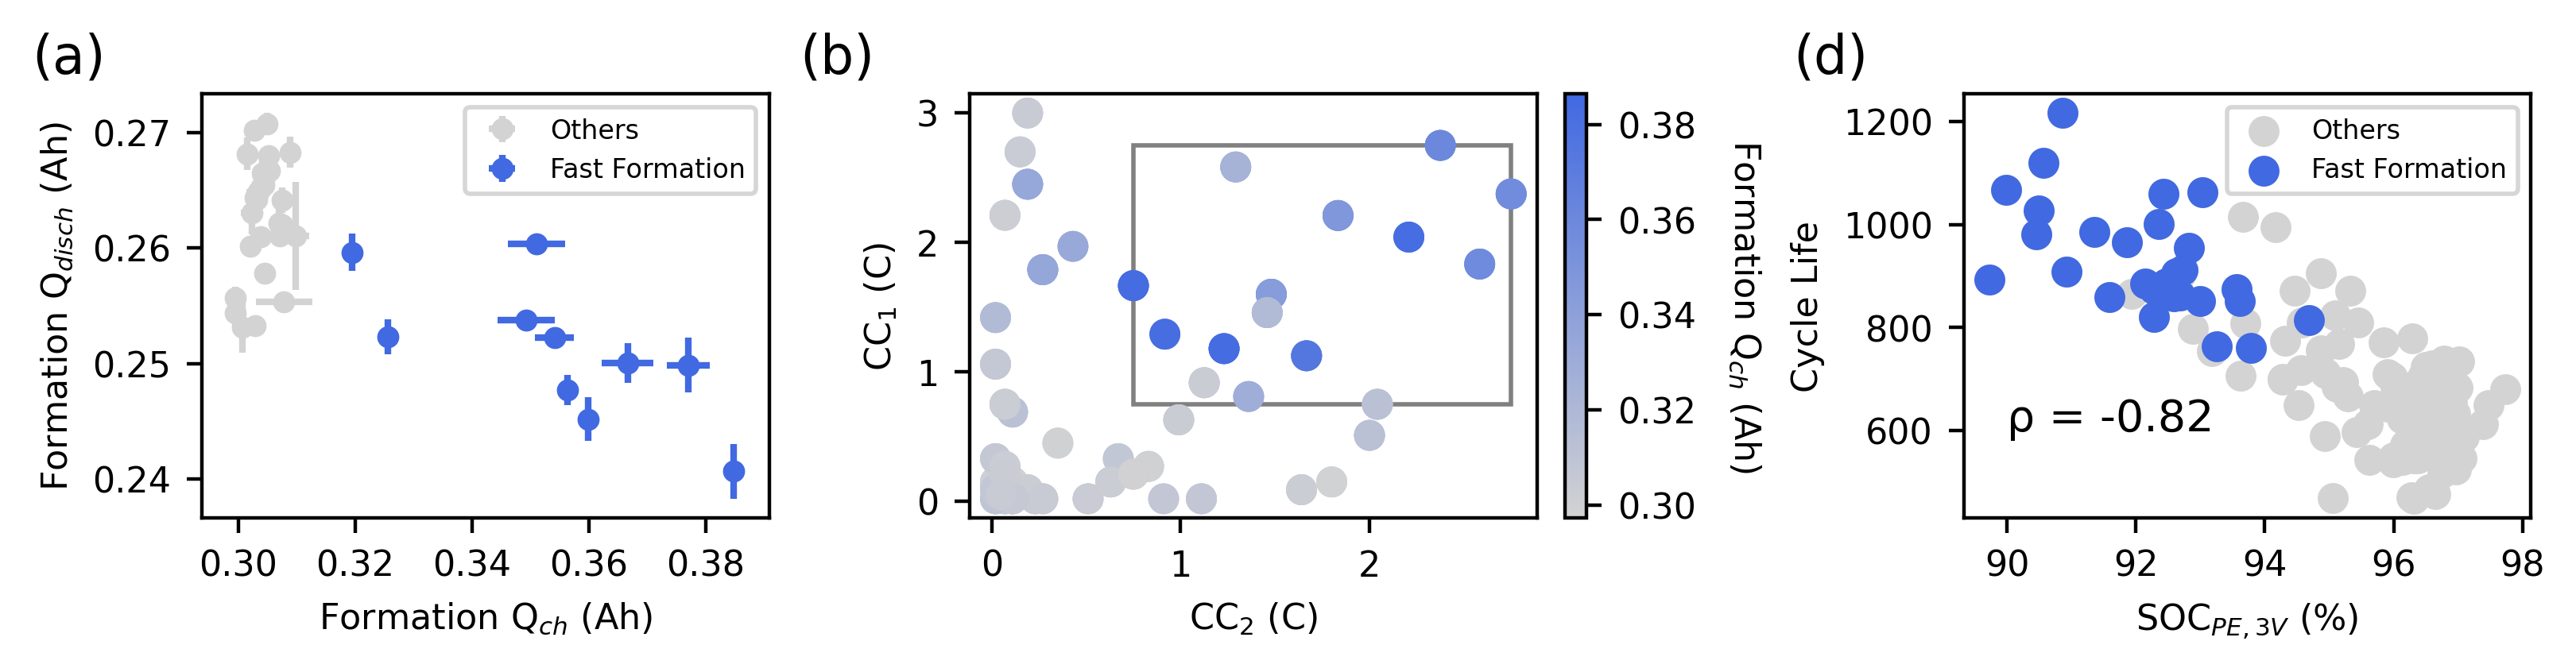

In [7]:
num_cols = 3
num_rows = 1
fig, axs = plt.subplots(num_rows, num_cols, figsize=(8/3*num_cols, 2*num_rows), dpi = 400, constrained_layout=True)
axs = axs.ravel()

rectangle = patches.Rectangle((0.75, 0.75), 2, 2, fc=None, ec = 'grey', fill = False)
axs[1].add_patch(rectangle)
cm = LinearSegmentedColormap.from_list("yellow_to_blue", ["lightgrey", "royalblue"])
col = 'formation_charge_current_1'
c_col = 'formation_charge_current_2'
chosen = df_all[(df_all.cycle_index == 0)&(df_all['formation_temperature']<55)]
sc = axs[1].scatter(chosen[col]/0.24, chosen[c_col]/0.24, c = chosen['1st_ch_cap'], cmap=cm)
cbar = plt.colorbar(sc)
cbar.set_label('Formation Q$_{ch}$ (Ah)', rotation=270, labelpad = 15, fontsize = 8)
axs[1].set_ylabel("CC$_{1}$" + ' (C)', fontsize = 8)
axs[1].set_xlabel("CC$_{2}$" + ' (C)', fontsize = 8)

column_1 = '1st_ch_cap'
df_all_chosen_low_rate = chosen[(chosen['formation_charge_current_1']<0.24)&(chosen['formation_charge_current_2']<0.24)]
test_ordered_1 = plot_error_bar(df_all_chosen_low_rate, column_1, repeats)
df_all_chosen_high_rate = chosen[(chosen['formation_charge_current_1']>=0.24)&(chosen['formation_charge_current_2']>=0.24)]
test_ordered_2 = plot_error_bar(df_all_chosen_high_rate, column_1, repeats)

column_2 = 'disch_cap_with_cv'
test_ordered_3 = plot_error_bar(df_all_chosen_low_rate, column_2, repeats)
test_ordered_4 = plot_error_bar(df_all_chosen_high_rate, column_2, repeats)
axs[0].errorbar(test_ordered_1[column_1 + '_mean'], test_ordered_3[column_2 + '_mean'], xerr= 1*test_ordered_1[column_1 + '_std']/np.sqrt(test_ordered_1[column_1 + '_num']),
             yerr= 1*test_ordered_3[column_2 + '_std']/np.sqrt(test_ordered_3[column_2 + '_num']), 
             fmt="o", color = 'lightgrey', markersize = 4, label = 'Others')
axs[0].errorbar(test_ordered_2[column_1 + '_mean'], test_ordered_4[column_2 + '_mean'], xerr= 1*test_ordered_2[column_1 + '_std']/np.sqrt(test_ordered_2[column_1 + '_num']),
             yerr= 1*test_ordered_4[column_2 + '_std']/np.sqrt(test_ordered_4[column_2 + '_num']), 
             fmt="o", color = 'royalblue', markersize = 4, label = 'Fast Formation')
# axs[0].set_ylim([df_all_chosen[column_2].min()-0.001, df_all_chosen[column_2].min()-0.001 + df_all_chosen[column_1].max()-df_all_chosen[column_1].min()])
axs[0].set_xlabel('Formation Q$_{ch}$ (Ah)', fontsize = 8)
axs[0].set_ylabel('Formation Q$_{disch}$ (Ah)', fontsize = 8)
axs[0].legend(loc='best', fontsize = 6)

corr = scipy.stats.pearsonr(chosen['SOC_pe_0'], chosen['regu_life'])[0]
axs[2].scatter(chosen.SOC_pe_0, chosen.regu_life, color = 'lightgrey', label = 'Others')
chosen = df_all[(df_all.cycle_index == 0)&(df_all.seq_num.isin(batch_1))
                &(df_all.formation_charge_current_1>0.24)&(df_all.formation_charge_current_2>0.24)
                &(df_all.formation_temperature<55)]
axs[2].scatter(chosen.SOC_pe_0, chosen.regu_life, color = 'royalblue', label = 'Fast Formation')
axs[2].set_xlabel('SOC$_{PE, 3V}$ (%)', fontsize = 8)
axs[2].set_ylabel('Cycle Life', fontsize = 8)
axs[2].legend(loc = 'best', fontsize = 6)
axs[2].text(90, 600, '\u03C1 = ' + "%.2f" % corr)

labels = ['(a)', '(b)', '(d)']
for i, ax in enumerate(axs):
    ax.text(-0.3, 1.05, labels[i], transform=ax.transAxes, size=12)
    

# plt.savefig('Fig_3.pdf', format='pdf', dpi=500, bbox_inches='tight')

### Fig S18

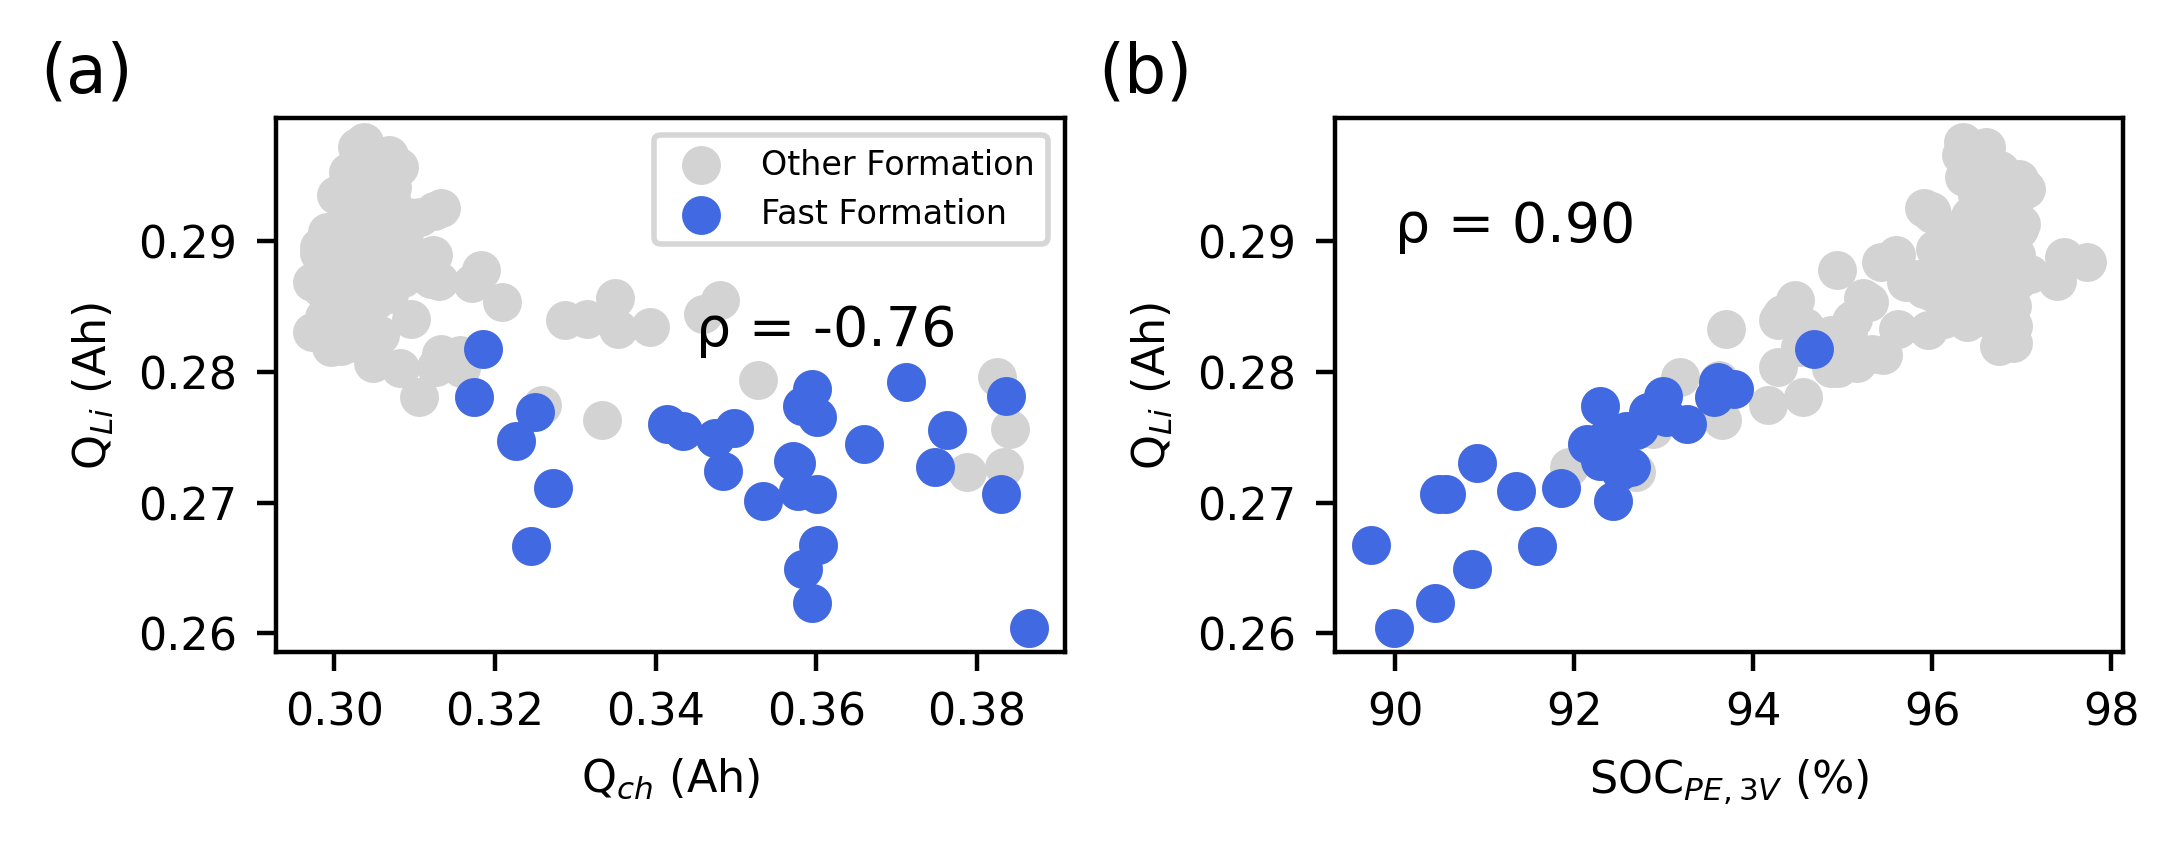

In [12]:
num_cols = 2
num_rows = 1
fig, axs = plt.subplots(num_rows, num_cols, figsize=(8/3*num_cols, 2*num_rows), dpi = 400, constrained_layout=True)

df_all_chosen = df_all[(df_all.cycle_index == 0)&(df_all.formation_temperature<55)]

x = '1st_ch_cap'
axs[0].scatter(df_all_chosen[x], df_all_chosen['Q_li']/1000, color = 'lightgrey', label = 'Other Formation')
corr = scipy.stats.pearsonr(df_all_chosen[x], df_all_chosen['Q_li'])[0]
axs[0].text(0.345, 0.282, '\u03C1 = ' + "%.2f" % corr)
chosen = df_all_chosen[(df_all_chosen.formation_charge_current_1>=0.24)&(df_all_chosen.formation_charge_current_2>=0.24)]
axs[0].scatter(chosen[x], chosen.Q_li/1000, color = 'royalblue', label = 'Fast Formation')
axs[0].set_ylabel('Q$_{Li}$ (Ah)', fontsize = 8)
axs[0].set_xlabel('Q$_{ch}$ (Ah)', fontsize = 8)

x = 'SOC_pe_0'
axs[1].scatter(df_all_chosen[x], df_all_chosen['Q_li']/1000, color = 'lightgrey', label = 'Other Formation')
corr = scipy.stats.pearsonr(df_all_chosen[x], df_all_chosen['Q_li'])[0]
axs[1].text(90, 0.29, '\u03C1 = ' + "%.2f" % corr)
chosen = df_all_chosen[(df_all_chosen.formation_charge_current_1>=0.24)&(df_all_chosen.formation_charge_current_2>=0.24)]
axs[1].scatter(chosen[x], chosen.Q_li/1000, color = 'royalblue', label = 'Fast Formation')
axs[1].set_ylabel('Q$_{Li}$ (Ah)', fontsize = 8)
axs[1].set_xlabel('SOC$_{PE, 3V}$ (%)', fontsize = 8)

for ax in axs:
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

labels = ['(a)', '(b)']
for i, ax in enumerate(axs):
    ax.text(-0.3, 1.05, labels[i], transform=ax.transAxes, size=12)

axs[0].legend(loc='best', fontsize = 6)

# plt.savefig('SI_figs/SI_Qch_Qli.pdf', format='pdf', dpi=500, bbox_inches='tight')